# HW12

## Neural Networks for Images

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework

In [1]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py

!wget -qO- https://github.com/DM-GY-9103-2024F-H/9103-utils/releases/latest/download/lfw.tar.gz | tar xz

In [2]:
import pandas as pd
import torch

from os import listdir, path
from sklearn.model_selection import train_test_split
from torch import nn, Tensor
from torch.utils.data import DataLoader

from data_utils import PCA, StandardScaler
from data_utils import classification_error, display_confusion_matrix
from data_utils import LFWUtils

from image_utils import make_image, open_image

from HW12_utils import HW12Utils, FaceDataset

## Neural Networks and PCA

We started seeing in class how Neural Networks can be _easy_ to build and explain in generic/abstract terms (a bunch of little operators that perform weighted sums of their inputs), but in reality can be really difficult and opaque to steer.

In theory, a couple of well placed neuron layers, with the right hyperparameters, learning rate, loss function, architecture and a good amount of data, can learn to extract information like polynomial features, clusters or PCA components. But... that's not always the case and sometimes it's not a bad idea to push/bias/encourage the network to go down a certain path.

One way to do this is to pre-process our inputs and do a bit of feature extraction ourselves.

Let's see if we can improve the face classification network from class by adding PCA information to our data.

### Start with the Data

As always, we start with the data, and this time put the pixel and label information straight into `Tensor` objects, but only so we can create a `DataLoader` for each of our datasets.

As a refresher... a `DataLoader` is a `PyTorch` objects that helps us _schedule_ how/when our data samples go through the model, by doing $2$ things, _batching_ and _shuffling_.

Batching is the process of selecting portions of our dataset, and shuffling is the process of switching the order of the samples before they go into batches.

There's usually no reason for shuffling the `test` dataset, but it's good to change up the order of our samples during training so the network doesn't learn just the order of the correct answers during training.

In [3]:
train, test = LFWUtils.train_test_split(0.5)

x_train = Tensor(train["pixels"])
y_train = Tensor(train["labels"]).long()

x_test = Tensor(test["pixels"])
y_test = Tensor(test["labels"]).long()

len(x_train), len(x_test)

(445, 438)

The `FaceDataset` class we saw in class is available in the `HW12_utils` file, so we can just use it here to wrap our `Tensor`s.

In [4]:
train_dataloader = DataLoader(FaceDataset(x_train, y_train), batch_size=128, shuffle=True)
test_dataloader = DataLoader(FaceDataset(x_test, y_test), batch_size=512)

### Let's train !

Oh no ! We don't have access to a GPU, so we can't use big neural networks.

Also, our dataset is kind of small, and only has at most $15$ samples from each class...

In these situations, it's not a bad idea to pre-process our data before sending it through training.

Let's create a single layer neural network, like the one from class, and train it with the `train_dataloader`.

In [5]:
# TODO: Create the model, optimizer and loss function objects

model = nn.Linear(x_train.shape[1], len(y_train.unique()))

learning_rate = 1e-6
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()


### The Loop

Create a training loop like we saw in class.

The inner part of this loop should:
- Iterate through all batches of our `DataLoader`
- For each batch, predict classes
- Measure `loss`
- Get the optimizer to compute gradients
- Update parameters

This inner loop should be repeated as long as the loss keeps improving, and it doesn't look like the model is overfitting with the training data.

In order to check if the model is overfitting, we should sporadically run evaluation within the training loop in order to see if the model performs similarly with `train` and `test` data.

We can use the `HW12Utils.get_labels(model, dataloader)` to run our `model` on all the data in a given `dataloader` and return the true labels and predicted labels for all samples.

In [18]:
train_labels, train_predictions = HW12Utils.get_labels(model, train_dataloader)
test_labels, test_predictions = HW12Utils.get_labels(model, test_dataloader)

# TODO: iterate epochs
  # TODO: iterate batches
    # TODO: predict
    # TODO: measure loss
    # TODO: compute gradient and step optimizer
    # TODO: show progress
train_losses = []

for e in range(32):
  model.train()  # Set model to training mode
  epoch_loss = 0

  for imgs, labels in train_dataloader:
    optim.zero_grad()
    labels_pred = model(imgs)
    loss = loss_fn(labels_pred, labels)
    loss.backward()
    optim.step()
    epoch_loss += loss.item()

  epoch_loss /= len(train_dataloader)
  train_losses.append(epoch_loss)
  
  # keep an eye on loss as we train
  if e % 4 == 3:
    print(f"Epoch: {e} loss: {loss.item():.4f}")

Epoch: 3 loss: 0.0481
Epoch: 7 loss: 0.9003
Epoch: 11 loss: 1.4234
Epoch: 15 loss: 0.5826
Epoch: 19 loss: 0.7609
Epoch: 23 loss: 0.3919
Epoch: 27 loss: 0.2326
Epoch: 31 loss: 0.0017


In [19]:
# TODO: iterate epochs
  # TODO: iterate batches
    # TODO: predict
    # TODO: measure loss
    # TODO: compute gradient and step optimizer
    # TODO: show progress
model1 = nn.Linear(x_test.shape[1], len(y_test.unique()))

learning_rate = 1e-6
optim = torch.optim.SGD(model1.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()
test_losses = []

for e in range(32):
  model1.train()  # Set model to test mode
  epoch_loss = 0

  for imgs, labels in test_dataloader:
    optim.zero_grad()
    labels_pred = model1(imgs)
    loss = loss_fn(labels_pred, labels)
    loss.backward()
    optim.step()
    epoch_loss += loss.item()

  epoch_loss /= len(test_dataloader)
  test_losses.append(epoch_loss)
  
  # keep an eye on loss as we test
  if e % 4 == 3:
    print(f"Epoch: {e} loss: {loss.item():.4f}")

Epoch: 3 loss: 79.0241
Epoch: 7 loss: 70.3512
Epoch: 11 loss: 51.9082
Epoch: 15 loss: 46.6161
Epoch: 19 loss: 44.2625
Epoch: 23 loss: 34.6126
Epoch: 27 loss: 37.1918
Epoch: 31 loss: 28.7148


### Evaluate

This should be similar to the last error values seen during training, but sometimes it changes a bit...

Not a bad idea to check the accuracy of the model using the `classification_error()` function, and look at some confusion matrices.

train error: 0.0562
test error: 0.5320


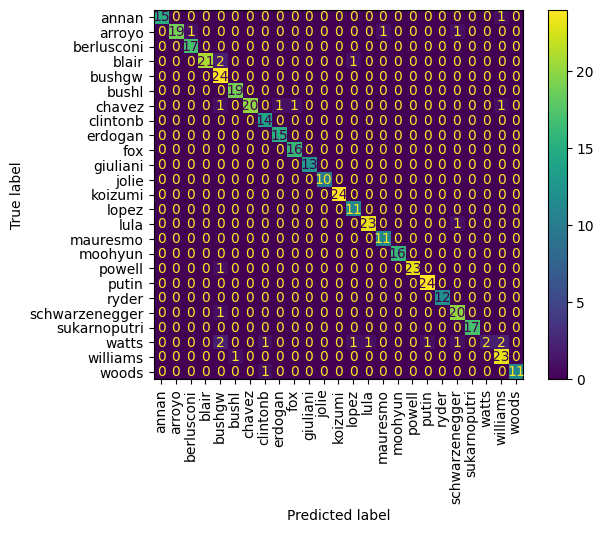

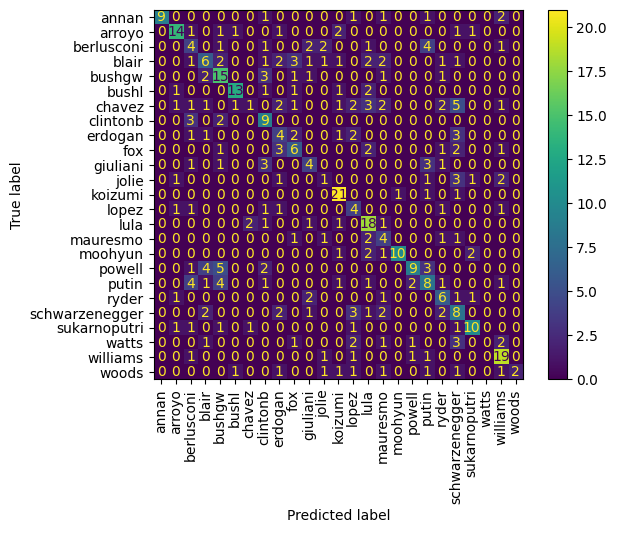

In [26]:

train_labels, train_predictions = HW12Utils.get_labels(model, train_dataloader)
test_labels, test_predictions = HW12Utils.get_labels(model, test_dataloader)


print("train error:", f"{classification_error(train_labels, train_predictions):.4f}")
print("test error:", f"{classification_error(test_labels, test_predictions):.4f}")

display_confusion_matrix(train_labels, train_predictions, display_labels=LFWUtils.LABELS)
display_confusion_matrix(test_labels, test_predictions, display_labels=LFWUtils.LABELS)


### Add PCA

We're going to repeat the training, but this time our data is gonna be scaled and PCA'd before going into the neural network.

Although it would be a bit unconventional for other types of models to scale `PCA` results, since our networks work better with scaled, well-proportioned data, here we'll have to scale the `PCA` results as well.

So, the data preparation flow should be:
- Scale data for `PCA`
- Perform `PCA`
- Scale data for Network

We need two `StandardScaler()` objects and one `PCA()` object.

The `train` data goes through the `fit_transform()` function of these objects, while the `test` data only goes through `transform()`.

For the `PCA`, an explained variance of about $90\%$ should be good, and, after the whole flow is set up, is something that can be experimented with.

In [ ]:
# TODO: Scale
# TODO: PCA
# TODO: Scale
# TODO: Tensors

### Repeat

Re-create `DataLoaders`, model, optimizer, loss function, then re-run the training loop and evaluate.

In [ ]:
# TODO: DataLoaders
# TODO: Model, Optimizer and Loss Function
# TODO: Training loop
# TODO: Evaluation

### Interpretation

<span style="color:hotpink;">
So... What happened ?<br>How does the <code>PCA</code> version of the NN compare to the regular version ?<br>How much of the improvement is from <code>PCA</code> and how much from scaling ?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>